In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

from lasso import *

import matplotlib.pyplot as plt
plt.style.use('dark_background')

/home/sauxpa/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/sauxpa/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/sauxpa/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,7),
}
plt.rcParams.update(params)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
scaler = StandardScaler()
housing = fetch_california_housing()
housing_data = scaler.fit_transform(housing.data)
housing_target = housing.target
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing_data]

In [4]:
n_epochs = int(1e3)
learning_rate = 0.01
momentum = 0.95
l1_strength = 0.5

In [5]:
model = Lasso()
model.X = housing_data_plus_bias
## VERY IMPORTANT : reshape y, 
## otherwise tf will do some messy inline reshaping, slowing down 50x
model.y = housing_target.reshape(-1,1)
model.n_epochs = n_epochs
model.verbose = False
model.l1_strength = l1_strength

## With gradient descent

In [6]:
model.optim_params = {
    'optimizer_name': 'gradient_descent',
    'learning_rate': learning_rate,
}

%timeit -n 1 -r 5 model.fit()
theta_gd = model.theta

299 ms ± 13.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## With Momentum

In [7]:
model.optim_params = {
    'optimizer_name': 'momentum',
    'learning_rate': learning_rate,
    'momentum': momentum,
}
%timeit -n 1 -r 5 model.fit()
theta_momentum = model.theta

338 ms ± 13.7 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## With Nesterov Momentum

In [8]:
model.optim_params = {
    'optimizer_name': 'nesterov',
    'learning_rate': learning_rate,
    'momentum': momentum,
}
%timeit -n 1 -r 5 model.fit()
theta_nesterov = model.theta

374 ms ± 21.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## With RMSProp

In [9]:
model.optim_params = {
    'optimizer_name': 'rmsprop',
    'learning_rate': learning_rate,
}
%timeit -n 1 -r 5 model.fit()
theta_rmsprop = model.theta

445 ms ± 24.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## With Adam

In [10]:
model.optim_params = {
    'optimizer_name': 'adam',
    'learning_rate': learning_rate,
}
%timeit -n 1 -r 5 model.fit()
theta_adam = model.theta

470 ms ± 16.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## With Follow The Regularized Leader

In [11]:
model.optim_params = {
    'optimizer_name': 'ftrl',
    'learning_rate': learning_rate,
}
%timeit -n 1 -r 5 model.fit()
theta_ftrl = model.theta

518 ms ± 39.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## With BFGS

In [12]:
def test_bfgs():
    X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name='X')
    y = tf.constant(housing_target.reshape(-1, 1), dtype=tf.float32, name='y')

    theta_start = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name='theta')

    def objective(theta):
        y_pred = tf.matmul(X, theta, name='predictions')
        error = y_pred - y
        mse = tf.reduce_mean(tf.square(error), name='mse')

        l1_regularizer = tf.contrib.layers.l1_regularizer(
                   scale=l1_strength, scope=None
                )

        regularization_penalty = tf.contrib.layers.apply_regularization(
            l1_regularizer,
            [theta])

        regularized_loss = mse + regularization_penalty
        gradients = tf.gradients(regularized_loss, [theta])[0]

        return regularized_loss, gradients

    training_op = tfp.optimizer.bfgs_minimize(
      objective, initial_position=theta_start, x_tolerance=1e-4)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        res = sess.run(training_op)
        assert(res.converged)
        return res.position

In [13]:
%timeit -n 1 -r 5 theta_bfgs = test_bfgs()
theta_bfgs = test_bfgs()

3.97 s ± 306 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


# Comparison
* Gradient descent : fast but struggles to converge to a sparse solution
* FGBS : slow but converges to a sparses solution
* Follow The Regularized Leader : fast (slightly slower than GD) and converges to an ever sparser solution


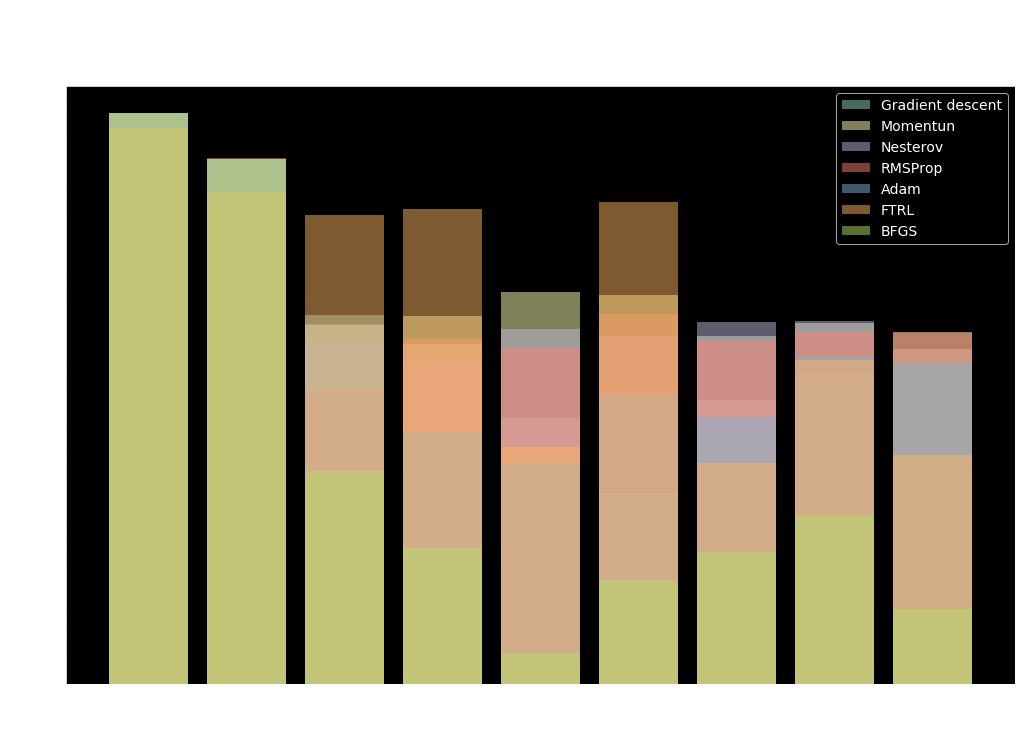

In [14]:
fig, ax = plt.subplots(figsize=(17, 11), nrows=1, ncols=1)

plt.suptitle('l1_strength={}'.format(l1_strength))

labels = ['Gradient descent', 'Momentun', 'Nesterov', 'RMSProp', 'Adam', 'FTRL', 'BFGS']
thetas = [theta_gd, theta_momentum, theta_nesterov, theta_rmsprop, theta_adam, theta_ftrl, theta_bfgs]

for theta, label in zip(thetas, labels):
    theta_transformed = np.abs(theta)
    index = range(theta_transformed.shape[0])
    ax.bar(index, theta_transformed.flatten(), label=label, alpha=0.5, log=True)
    
ax.legend(loc='upper right')
ax.set_xlabel(r'Component of $\theta$')
ax.set_ylabel('Value')
plt.show()

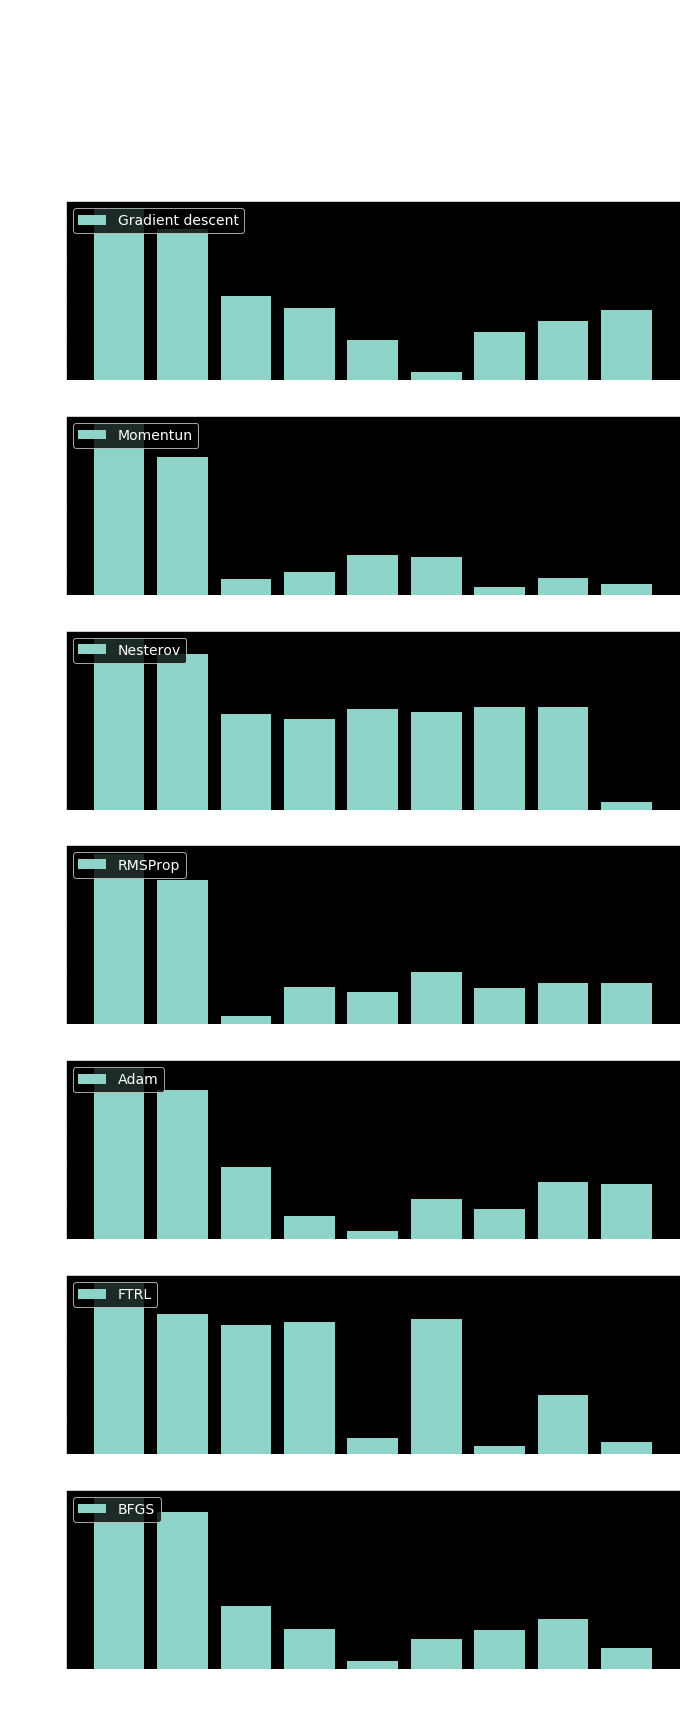

In [15]:
fig, axes = plt.subplots(figsize=(11, 27), nrows=7, ncols=1)

plt.suptitle('l1_strength={}'.format(l1_strength))

labels = ['Gradient descent', 'Momentun', 'Nesterov', 'RMSProp', 'Adam', 'FTRL', 'BFGS']
thetas = [theta_gd, theta_momentum, theta_nesterov, theta_rmsprop, theta_adam, theta_ftrl, theta_bfgs]

for i, ax in enumerate(axes):
    theta_transformed = np.abs(thetas[i])
    
    index = range(theta_transformed.shape[0])
    ax.bar(index, theta_transformed.flatten(), label=labels[i], log=True)
    ax.legend(loc='upper left')

ax.set_xlabel(r'Component of $\theta$')
ax.set_ylabel('Value')
plt.show()

## Lasso paths

With only 1000 epochs, gradient descent is slightly unstable for small l1 penalties.

In [16]:
n_l1_strength = 20
threshold = 5e-2

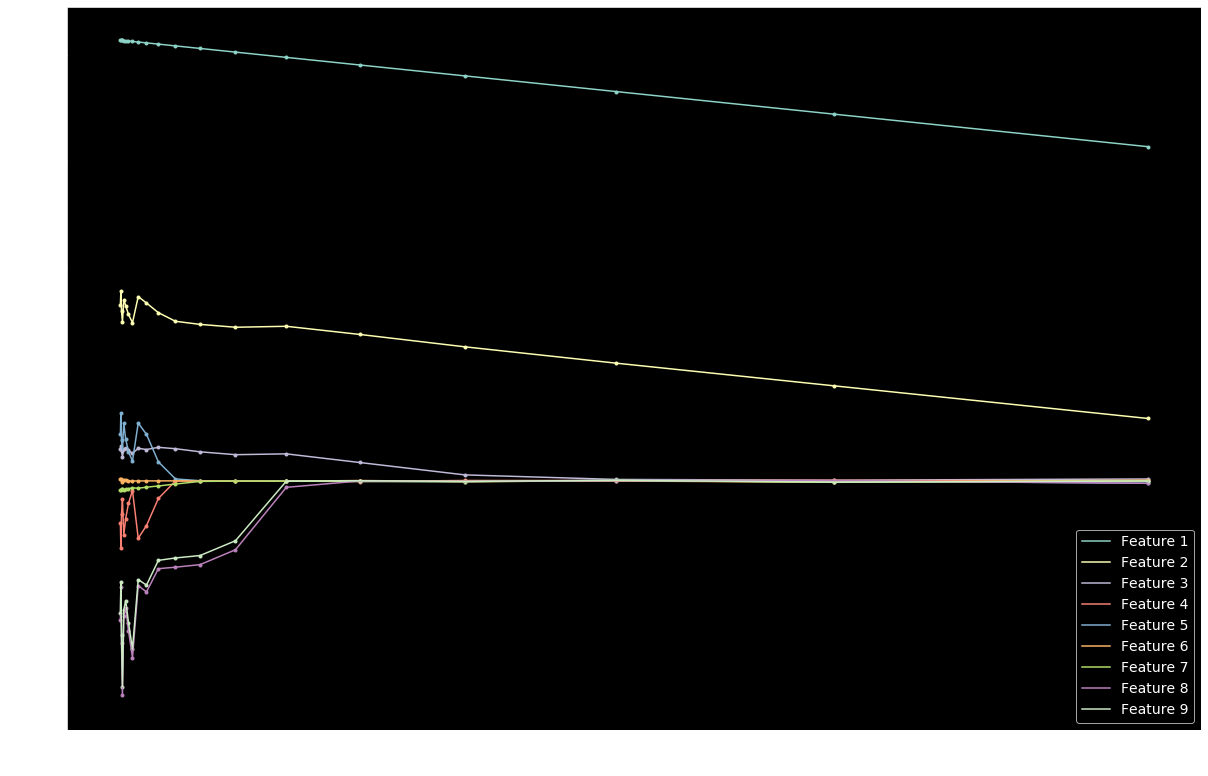

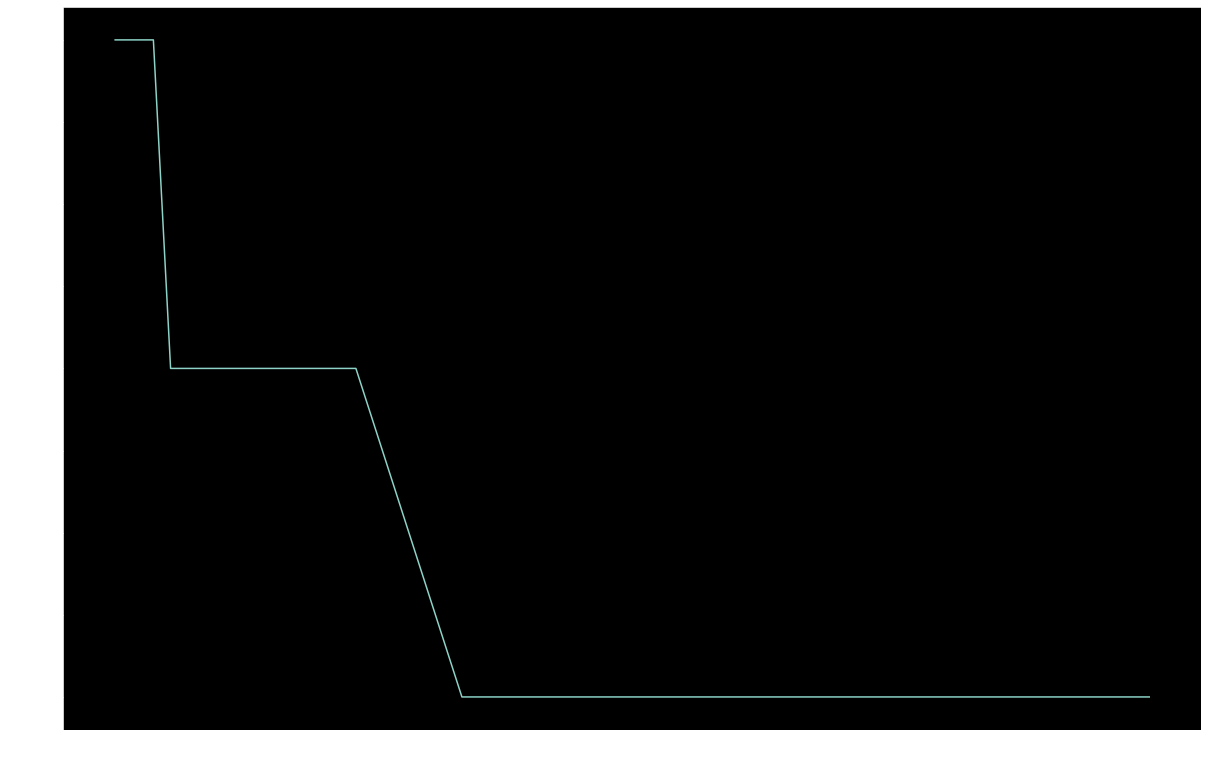

In [17]:
model.optim_params = {
    'optimizer_name': 'gradient_descent',
    'learning_rate': learning_rate,
}

path, active_features_path, grid = model.lasso_path(n_l1_strength=n_l1_strength,
                                                    plot_path=True, 
                                                    plot_active_features_path=True, 
                                                    threshold=threshold)

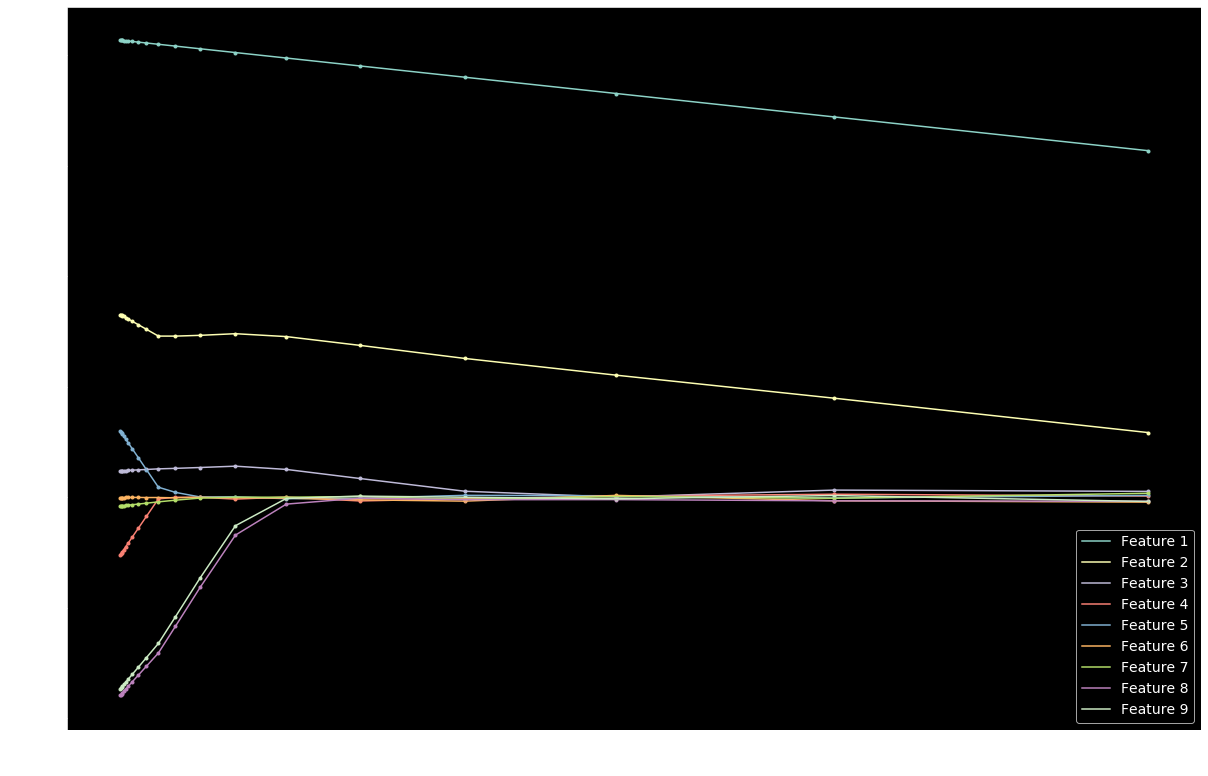

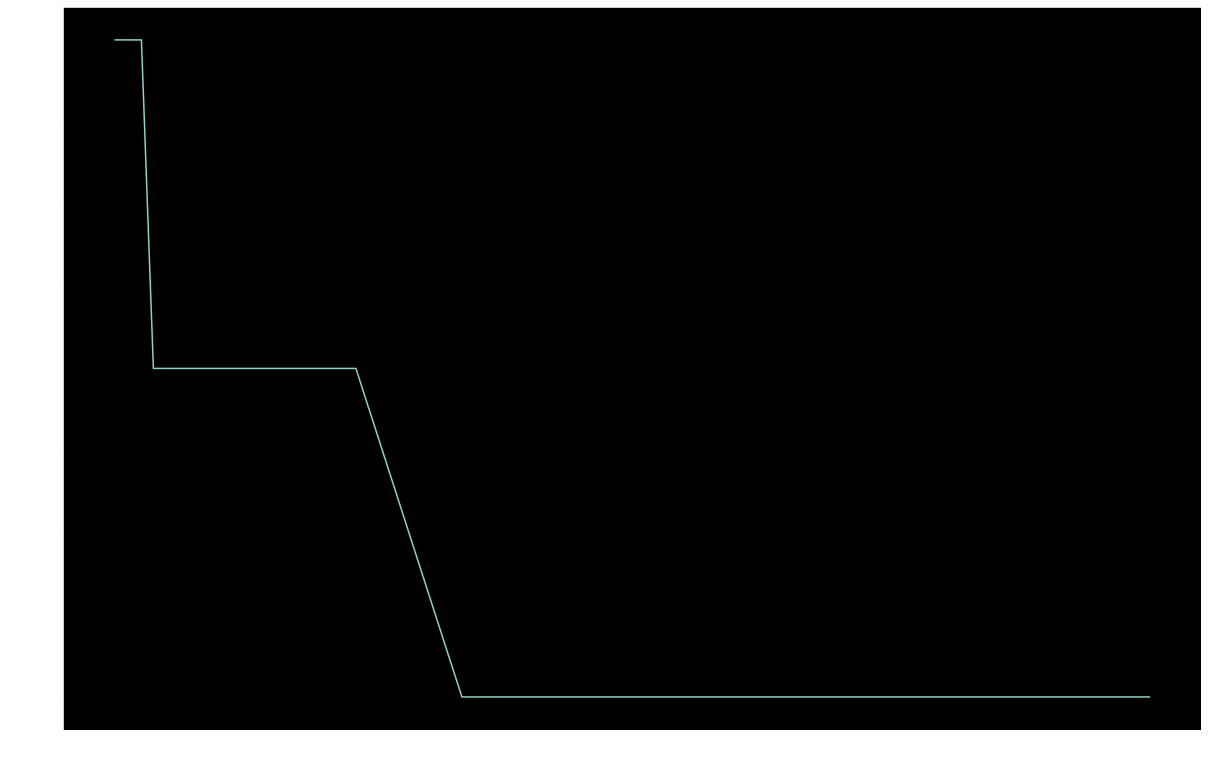

In [18]:
model.optim_params = {
    'optimizer_name': 'momentum',
    'learning_rate': learning_rate,
    'momentum': momentum,
}

path, active_features_path, grid = model.lasso_path(n_l1_strength=n_l1_strength,
                                                    plot_path=True, 
                                                    plot_active_features_path=True, 
                                                    threshold=threshold)

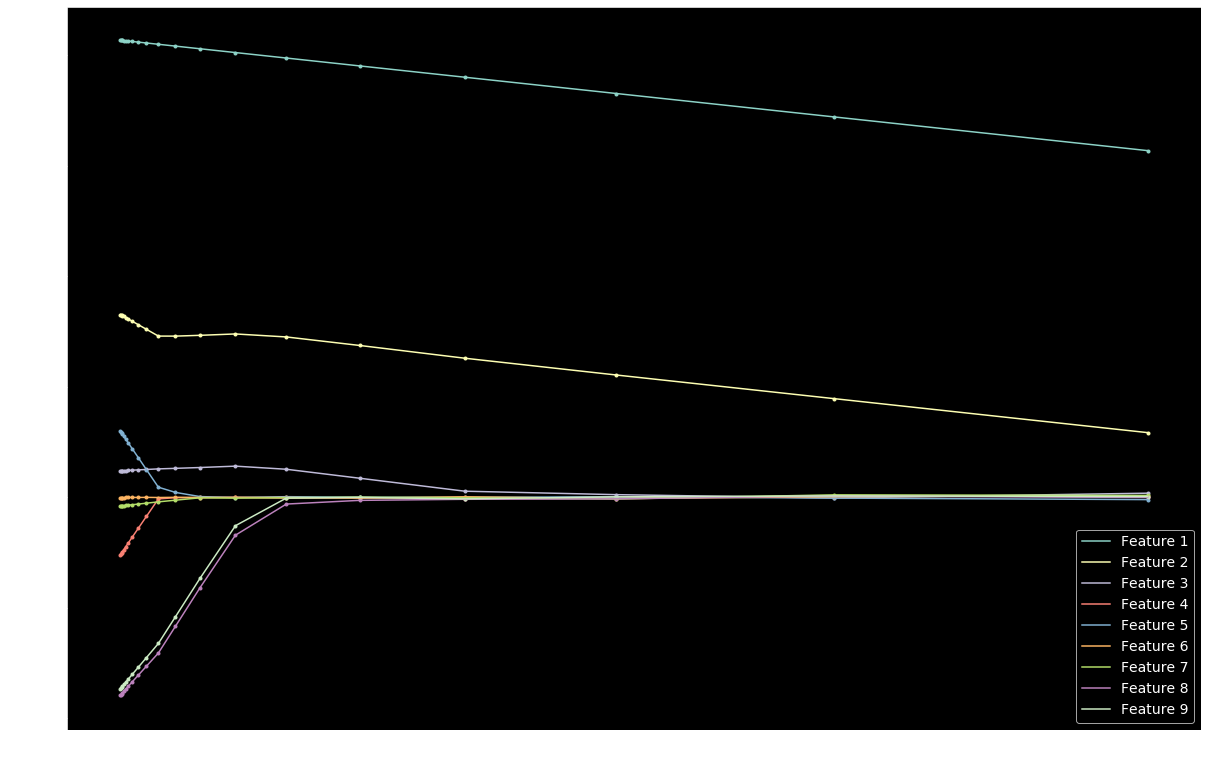

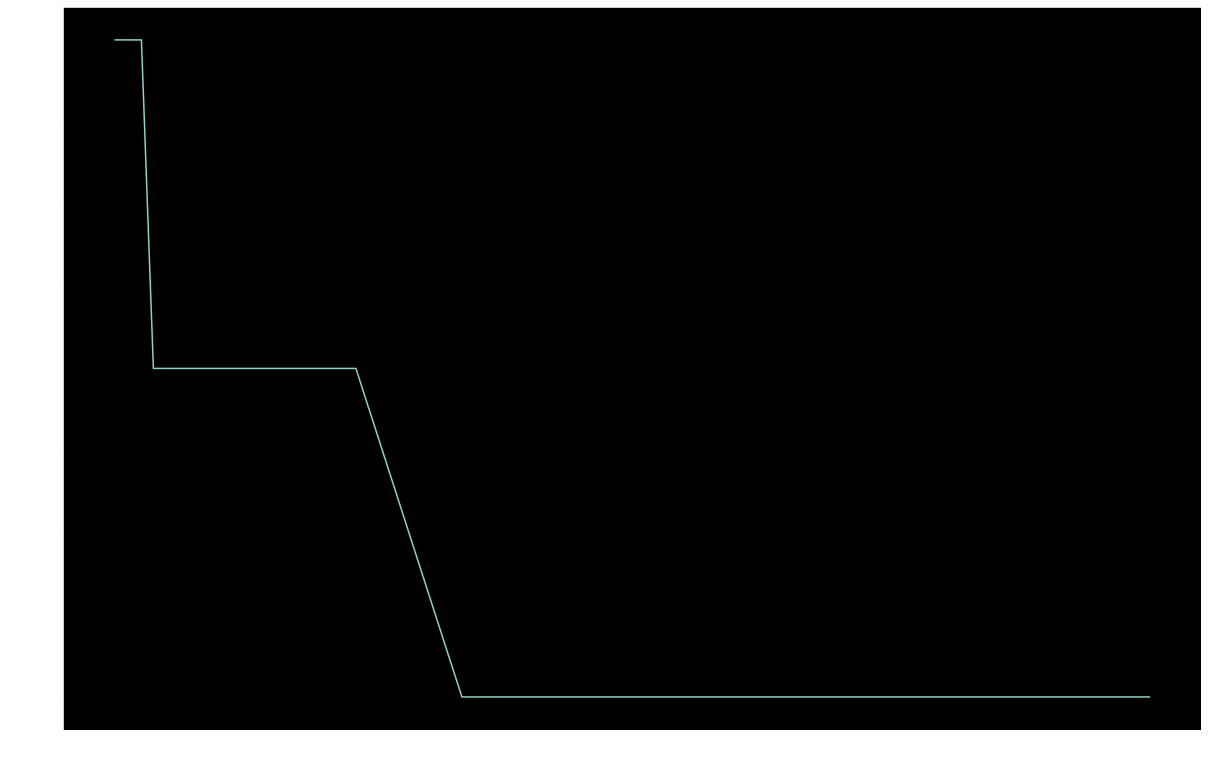

In [19]:
model.optim_params = {
    'optimizer_name': 'nesterov',
    'learning_rate': learning_rate,
    'momentum': momentum,
}

path, active_features_path, grid = model.lasso_path(n_l1_strength=n_l1_strength,
                                                    plot_path=True, 
                                                    plot_active_features_path=True, 
                                                    threshold=threshold)

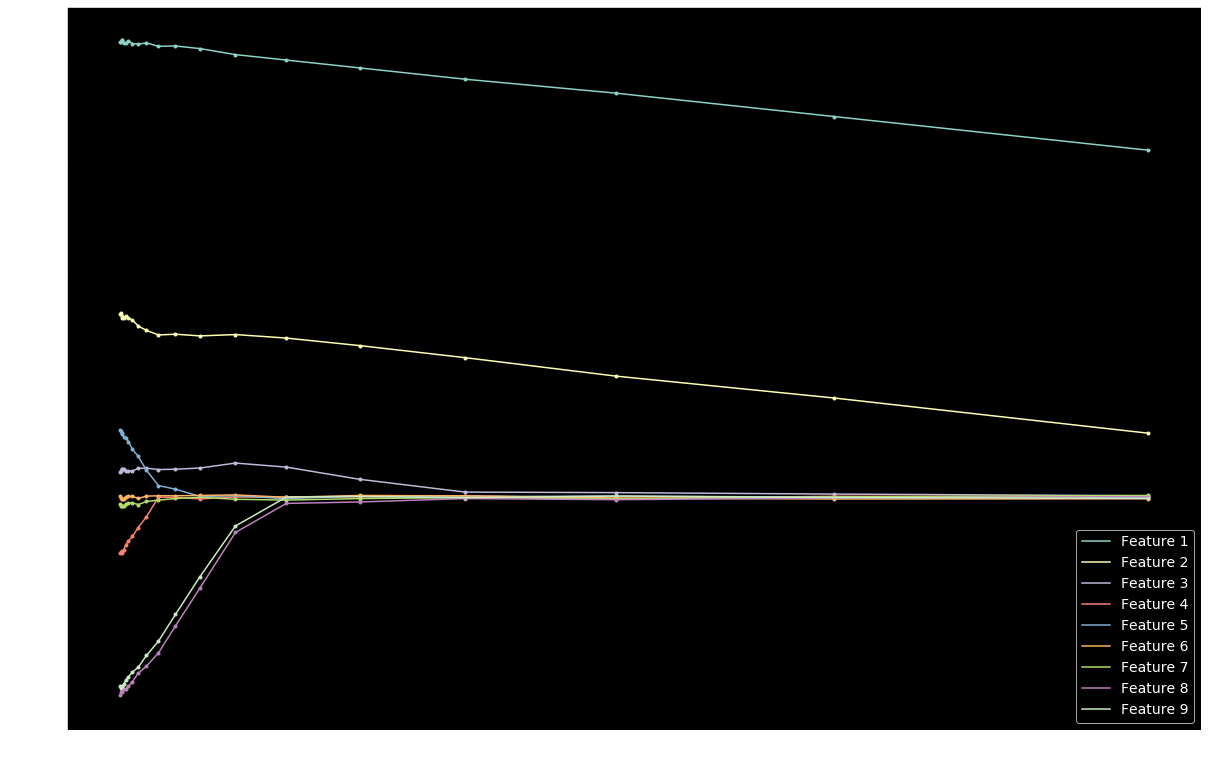

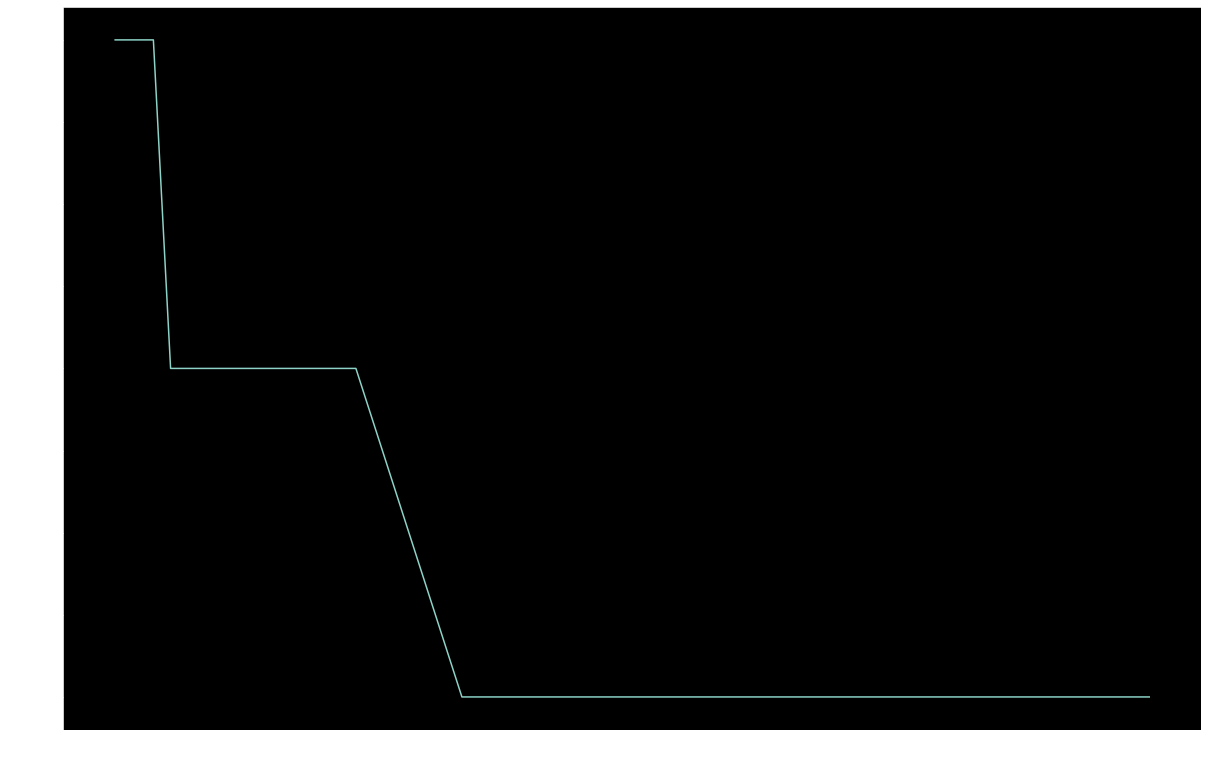

In [20]:
model.optim_params = {
    'optimizer_name': 'rmsprop',
    'learning_rate': learning_rate,
}

path, active_features_path, grid = model.lasso_path(n_l1_strength=n_l1_strength,
                                                    plot_path=True, 
                                                    plot_active_features_path=True, 
                                                    threshold=threshold)

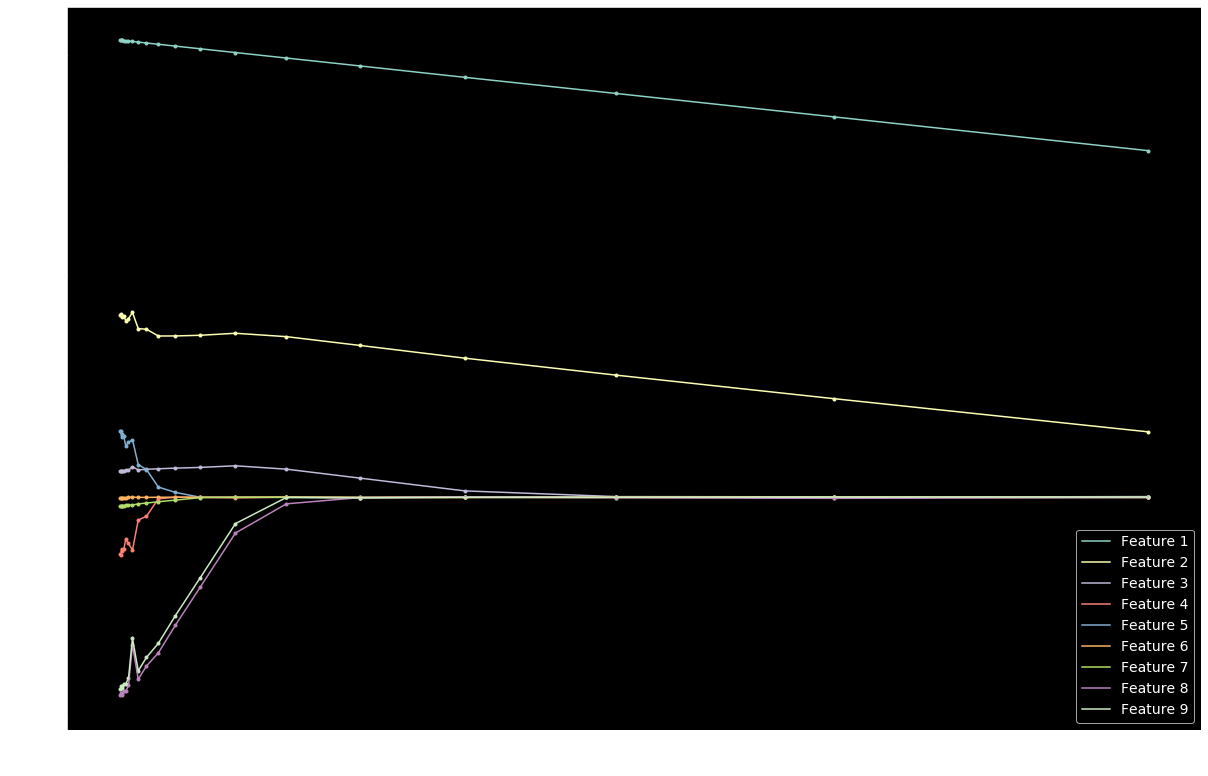

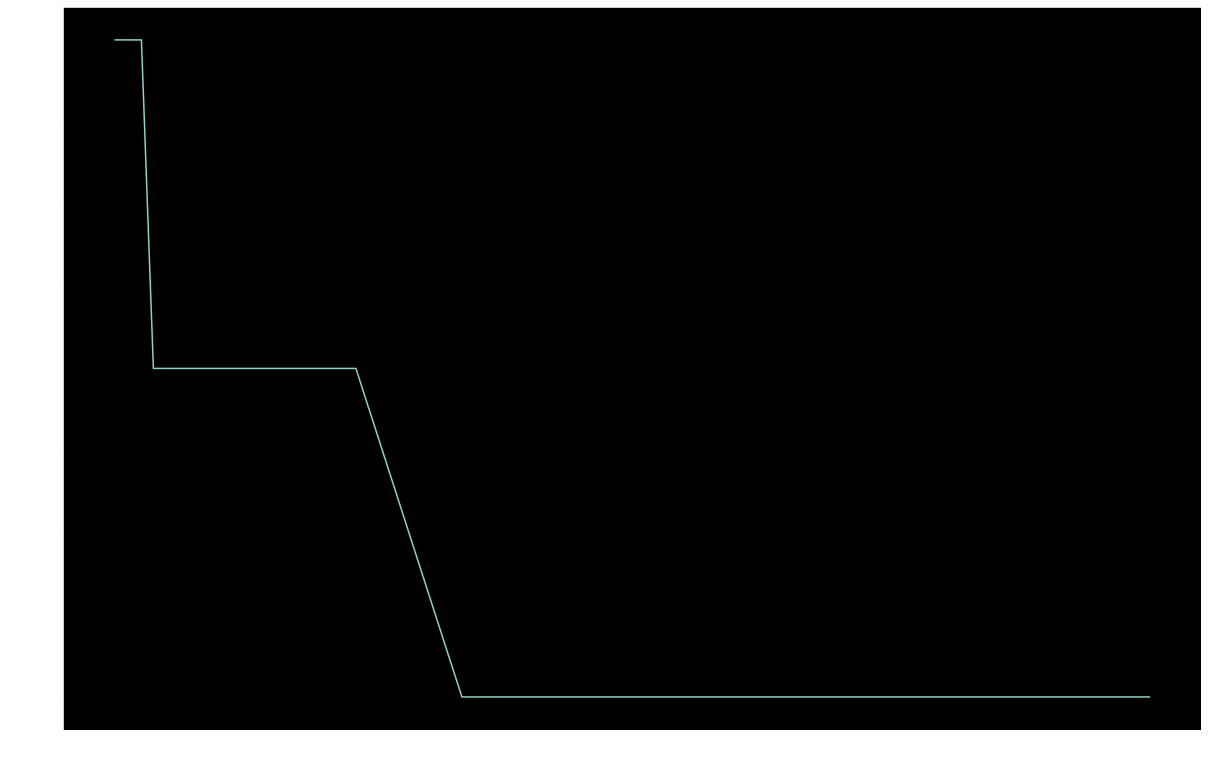

In [21]:
model.optim_params = {
    'optimizer_name': 'adam',
    'learning_rate': learning_rate,
}

path, active_features_path, grid = model.lasso_path(n_l1_strength=n_l1_strength,
                                                    plot_path=True, 
                                                    plot_active_features_path=True, 
                                                    threshold=threshold)

## FTRL struggles to generate stable lasso paths and requires more epochs to converge


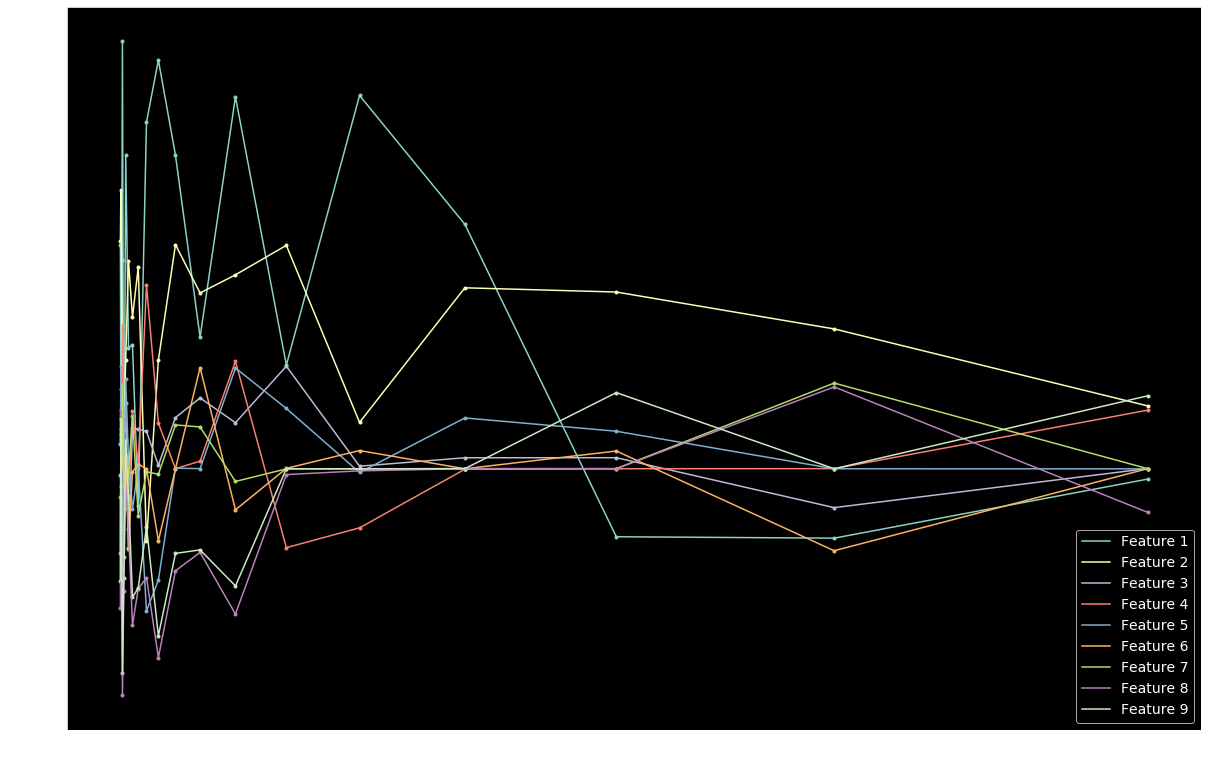

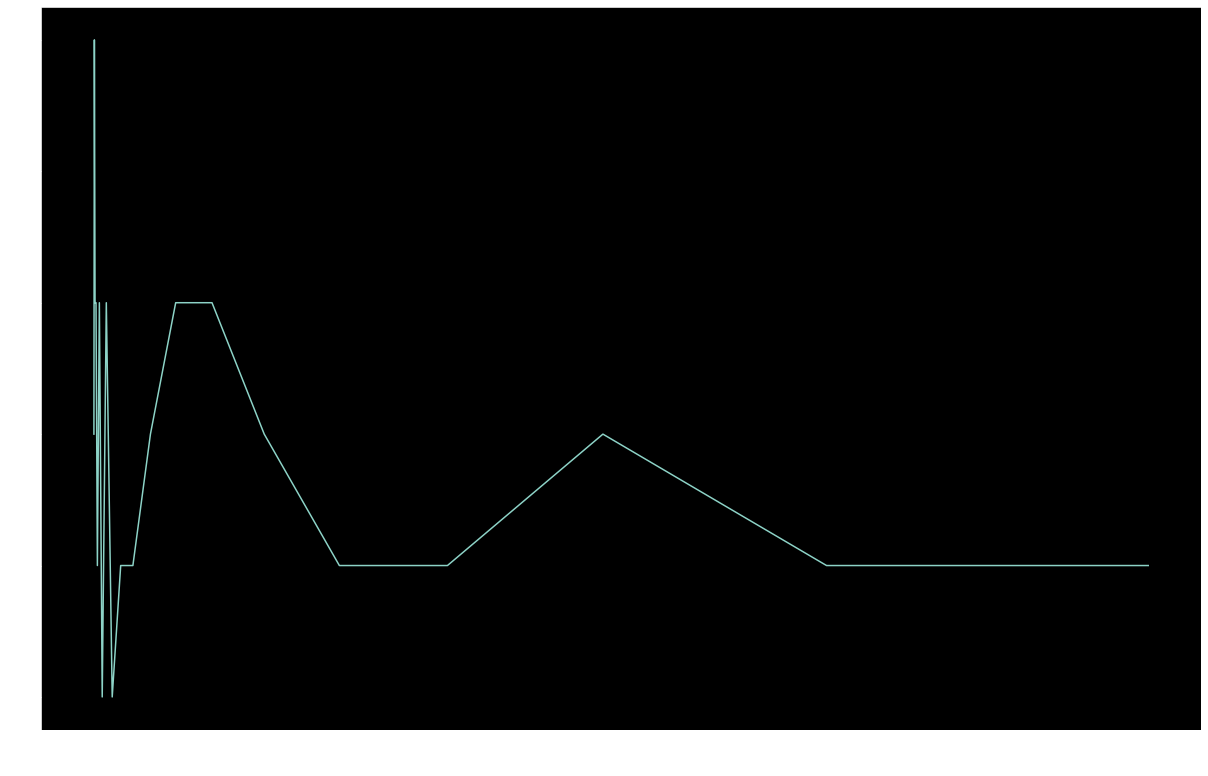

In [22]:
model.optim_params = {
    'optimizer_name': 'ftrl',
    'learning_rate': learning_rate,
}

path, active_features_path, grid = model.lasso_path(n_l1_strength=n_l1_strength,
                                                    plot_path=True, 
                                                    plot_active_features_path=True, 
                                                    threshold=threshold)

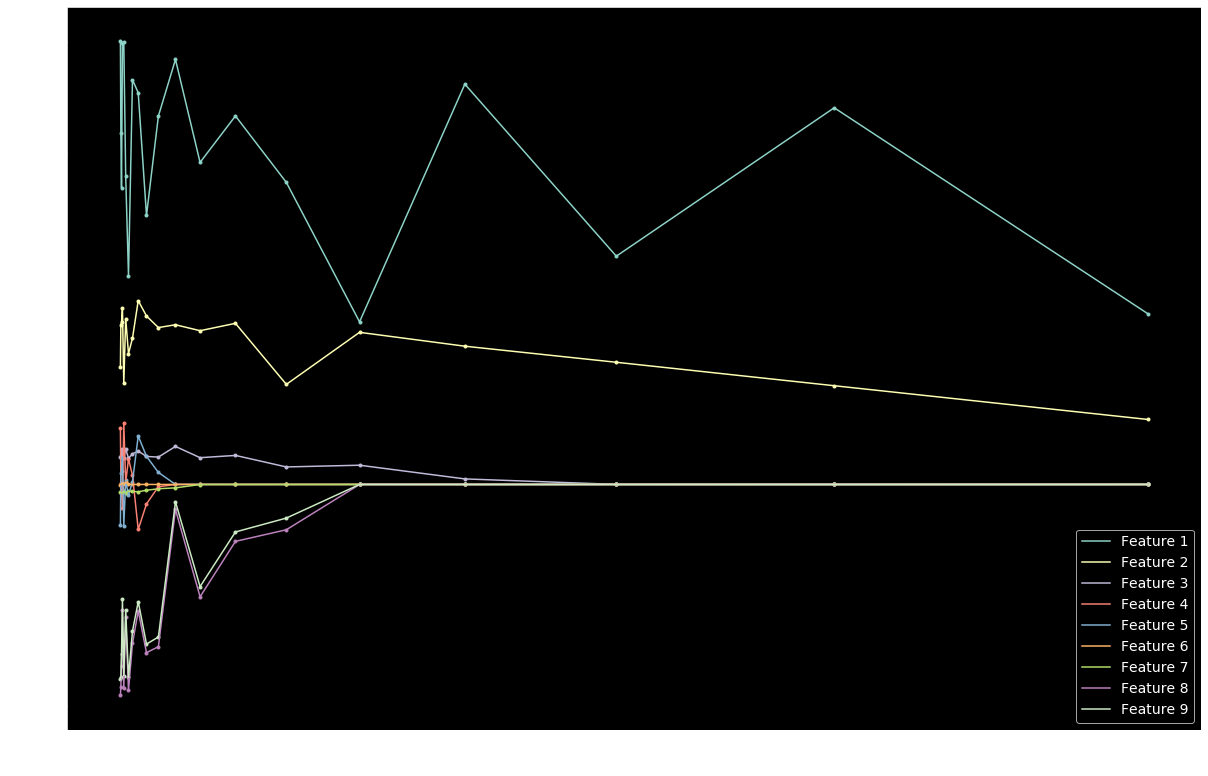

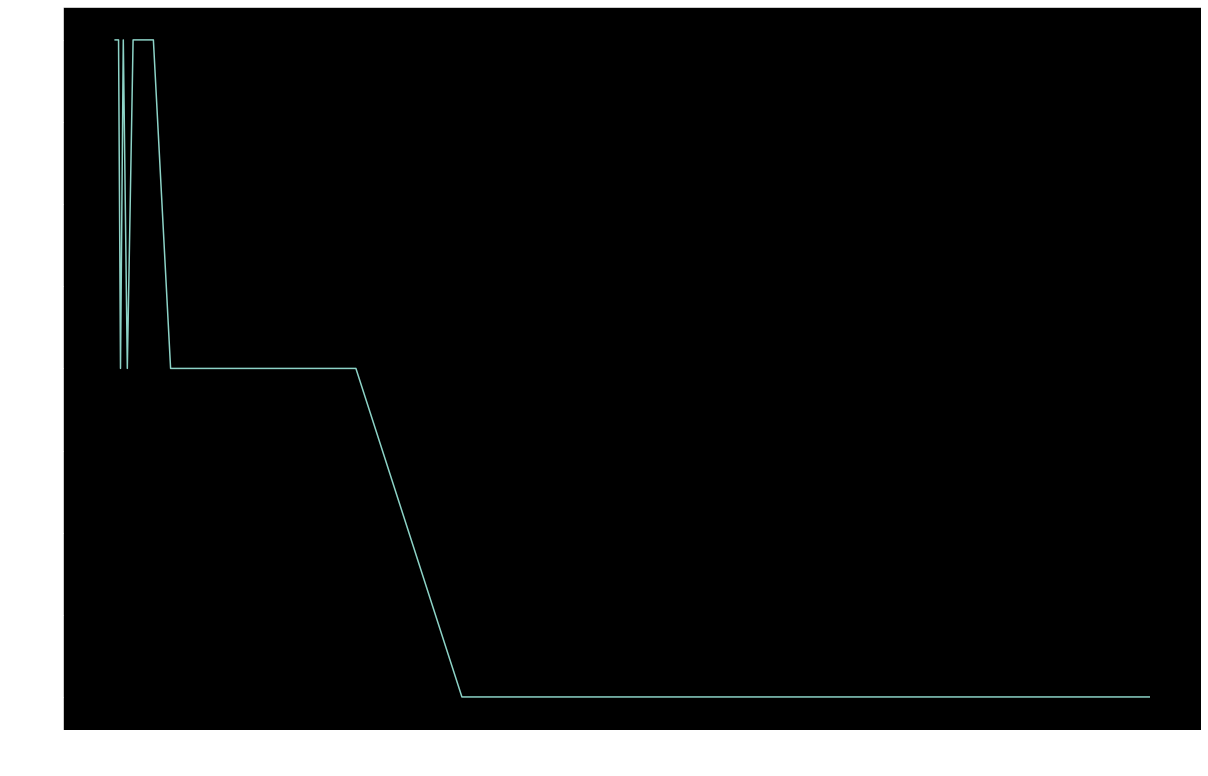

In [23]:
model.optim_params = {
    'optimizer_name': 'ftrl',
    'learning_rate': learning_rate,
}

model.n_epochs *= 10
path, active_features_path, grid = model.lasso_path(n_l1_strength=n_l1_strength,
                                                    plot_path=True, 
                                                    plot_active_features_path=True, 
                                                    threshold=threshold)